In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import sys
sys.path.append('src/')

import csv
from palettes import DEFAULT_PALETTE
from WADParser import open_wad_file
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import struct
import re
from copy import deepcopy

from mus2mid3 import mus2mid

In [6]:
w = open_wad_file('WADs/DOOM.WAD')

2025-03-21 11:44:42.242 | INFO     | WADParser:__init__:41 - Found a DOOM IWAD.
2025-03-21 11:44:42.243 | INFO     | WADParser:_get_palette:127 - Palette extracted.
2025-03-21 11:44:42.248 | INFO     | WADParser:_parse_levels:167 - 36 levels found in this WAD.
2025-03-21 11:44:42.249 | INFO     | WADParser:_parse_by_markers:197 - 107 FLATS found in this WAD.
2025-03-21 11:44:42.250 | INFO     | WADParser:_parse_by_markers:197 - 764 SPRITES found in this WAD.
2025-03-21 11:44:42.300 | INFO     | WADParser:_parse_things:139 - DOOM THINGS loaded.
2025-03-21 11:44:42.304 | INFO     | WADParser:_gather_textures:375 - Found 287 textures in 2 texture lumps.


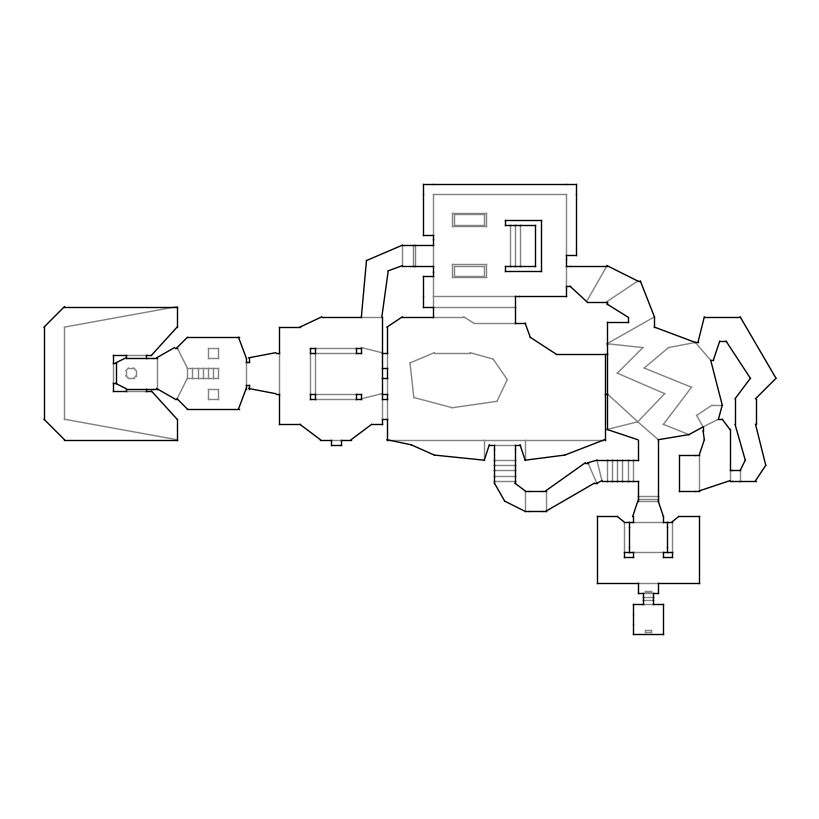

In [28]:
map_infos = w.map('E1M1')

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for line in map_infos['steps']:
        ax.plot(line[:, 0], line[:, 1], color='grey', linewidth=1)

for line in map_infos['walls']:
        ax.plot(line[:, 0], line[:, 1], color='black', linewidth=1)

ax.axis('off')
ax.axis('equal')
fig.tight_layout(pad=0)     

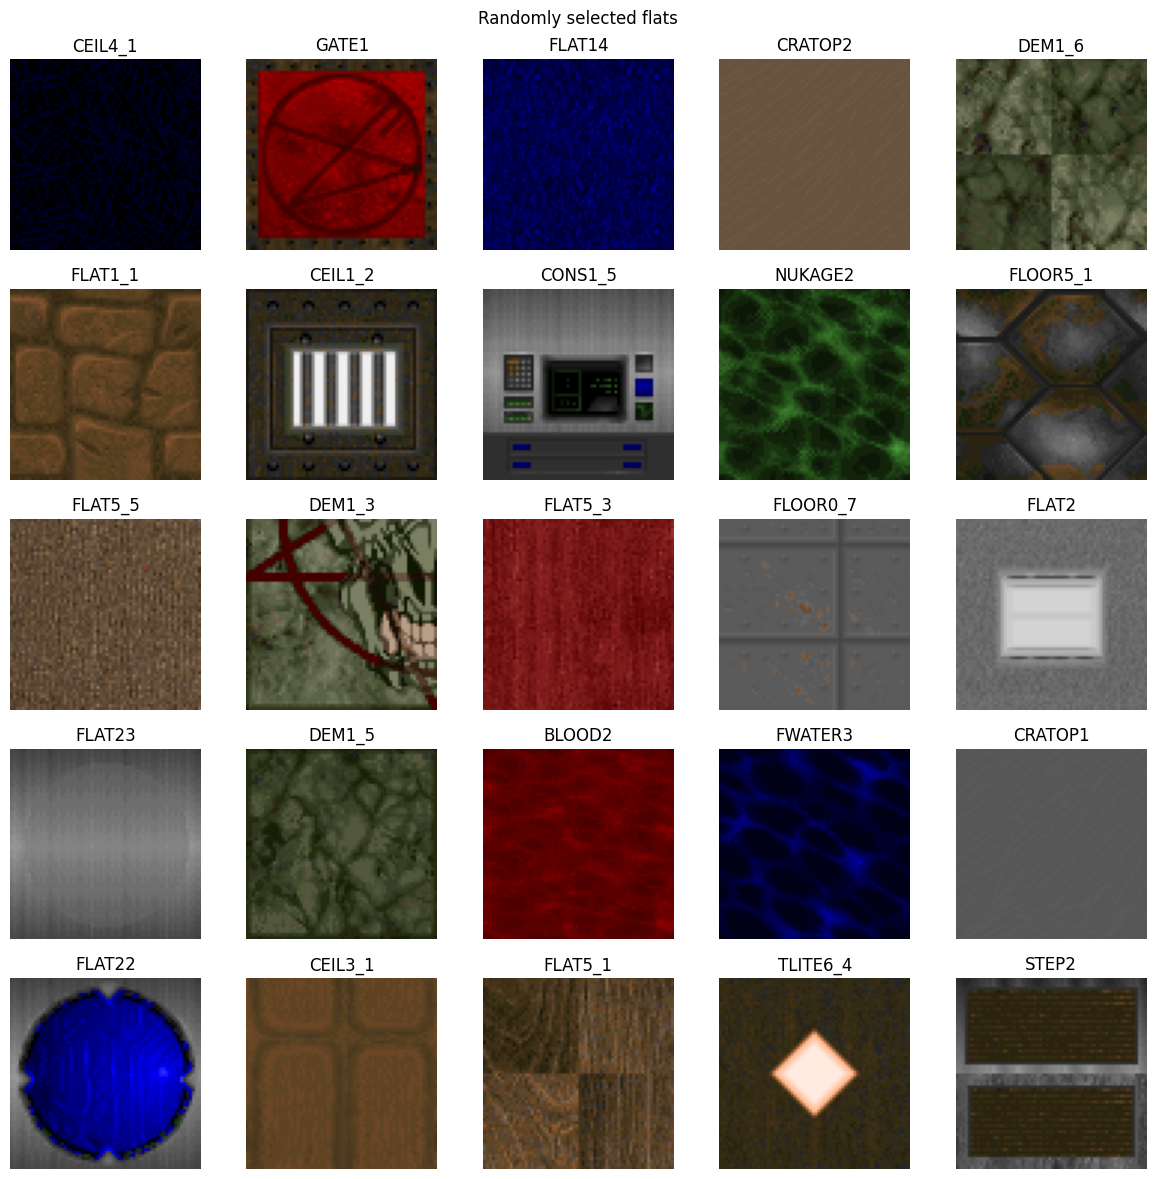

In [29]:
n_flats = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_flat_names = list(w.flats.keys())
selected_flats = np.random.choice(all_flat_names, size=n_flats, replace=False)

for i, flat_name in enumerate(selected_flats):

    rgb_image = w.draw_flat(*w.flats[flat_name])

    ax[i].imshow(rgb_image / 255, aspect='equal')
    ax[i].set_title(flat_name)
    ax[i].axis('off')

fig.suptitle('Randomly selected flats')
fig.tight_layout(pad=1.2)

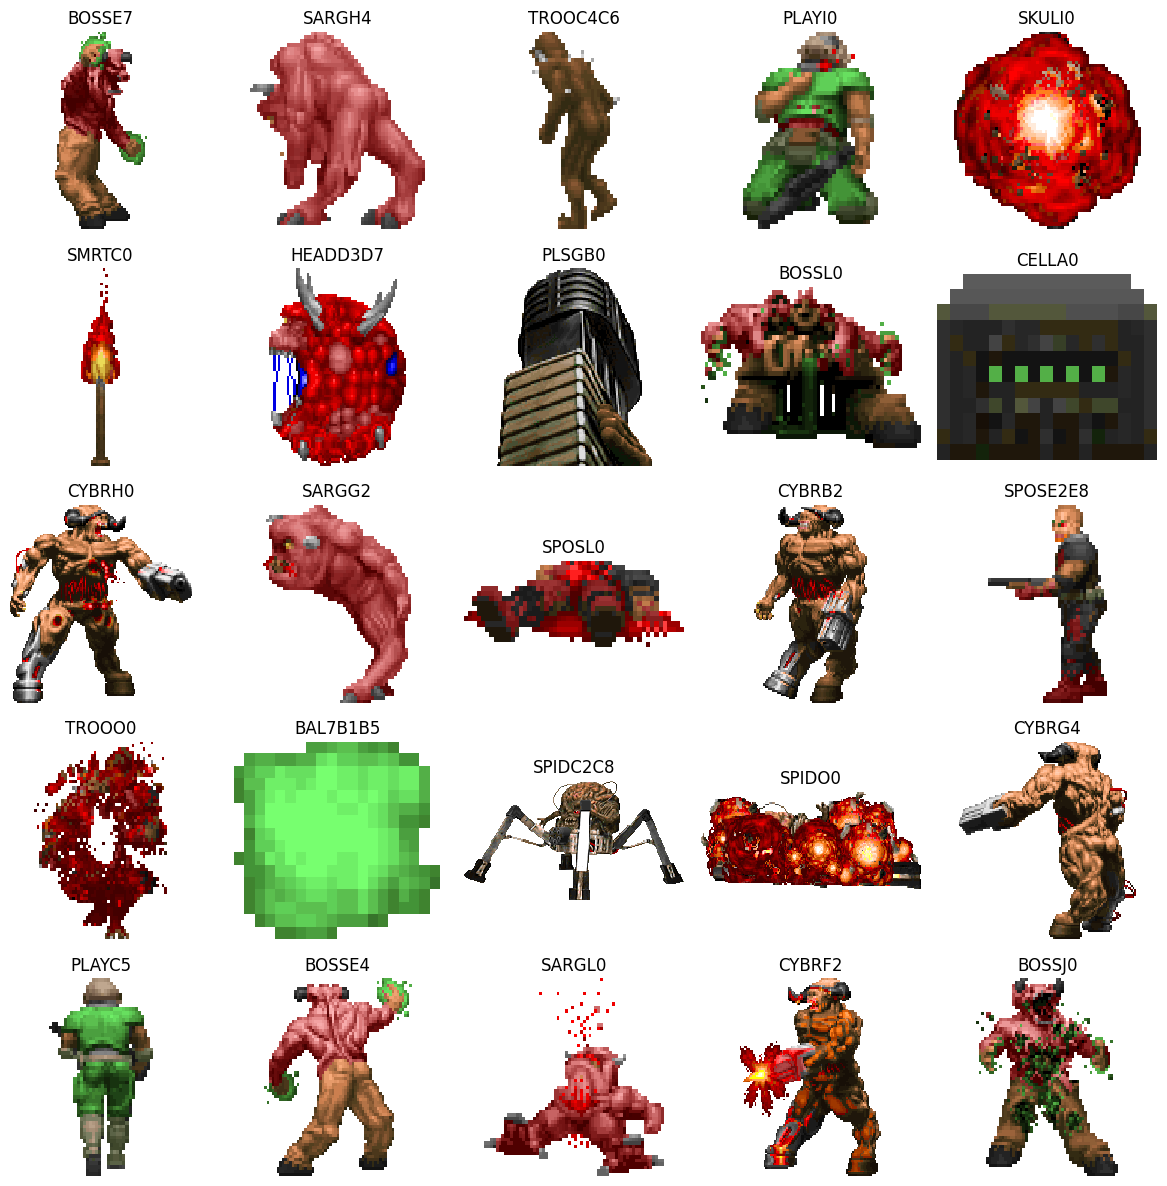

In [30]:
n_sprites = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_sprite_names = list(w.sprites.keys())
selected_sprites = np.random.choice(all_sprite_names, size=n_sprites, replace=False)

for i, sprite_name in enumerate(selected_sprites):

    rgb_image = w.draw_patch(*w.sprites[sprite_name])

    # Original DOOM had non-square pixels!
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest') 
    ax[i].set_title(sprite_name)
    ax[i].axis('off')

fig.tight_layout(pad=1.2)

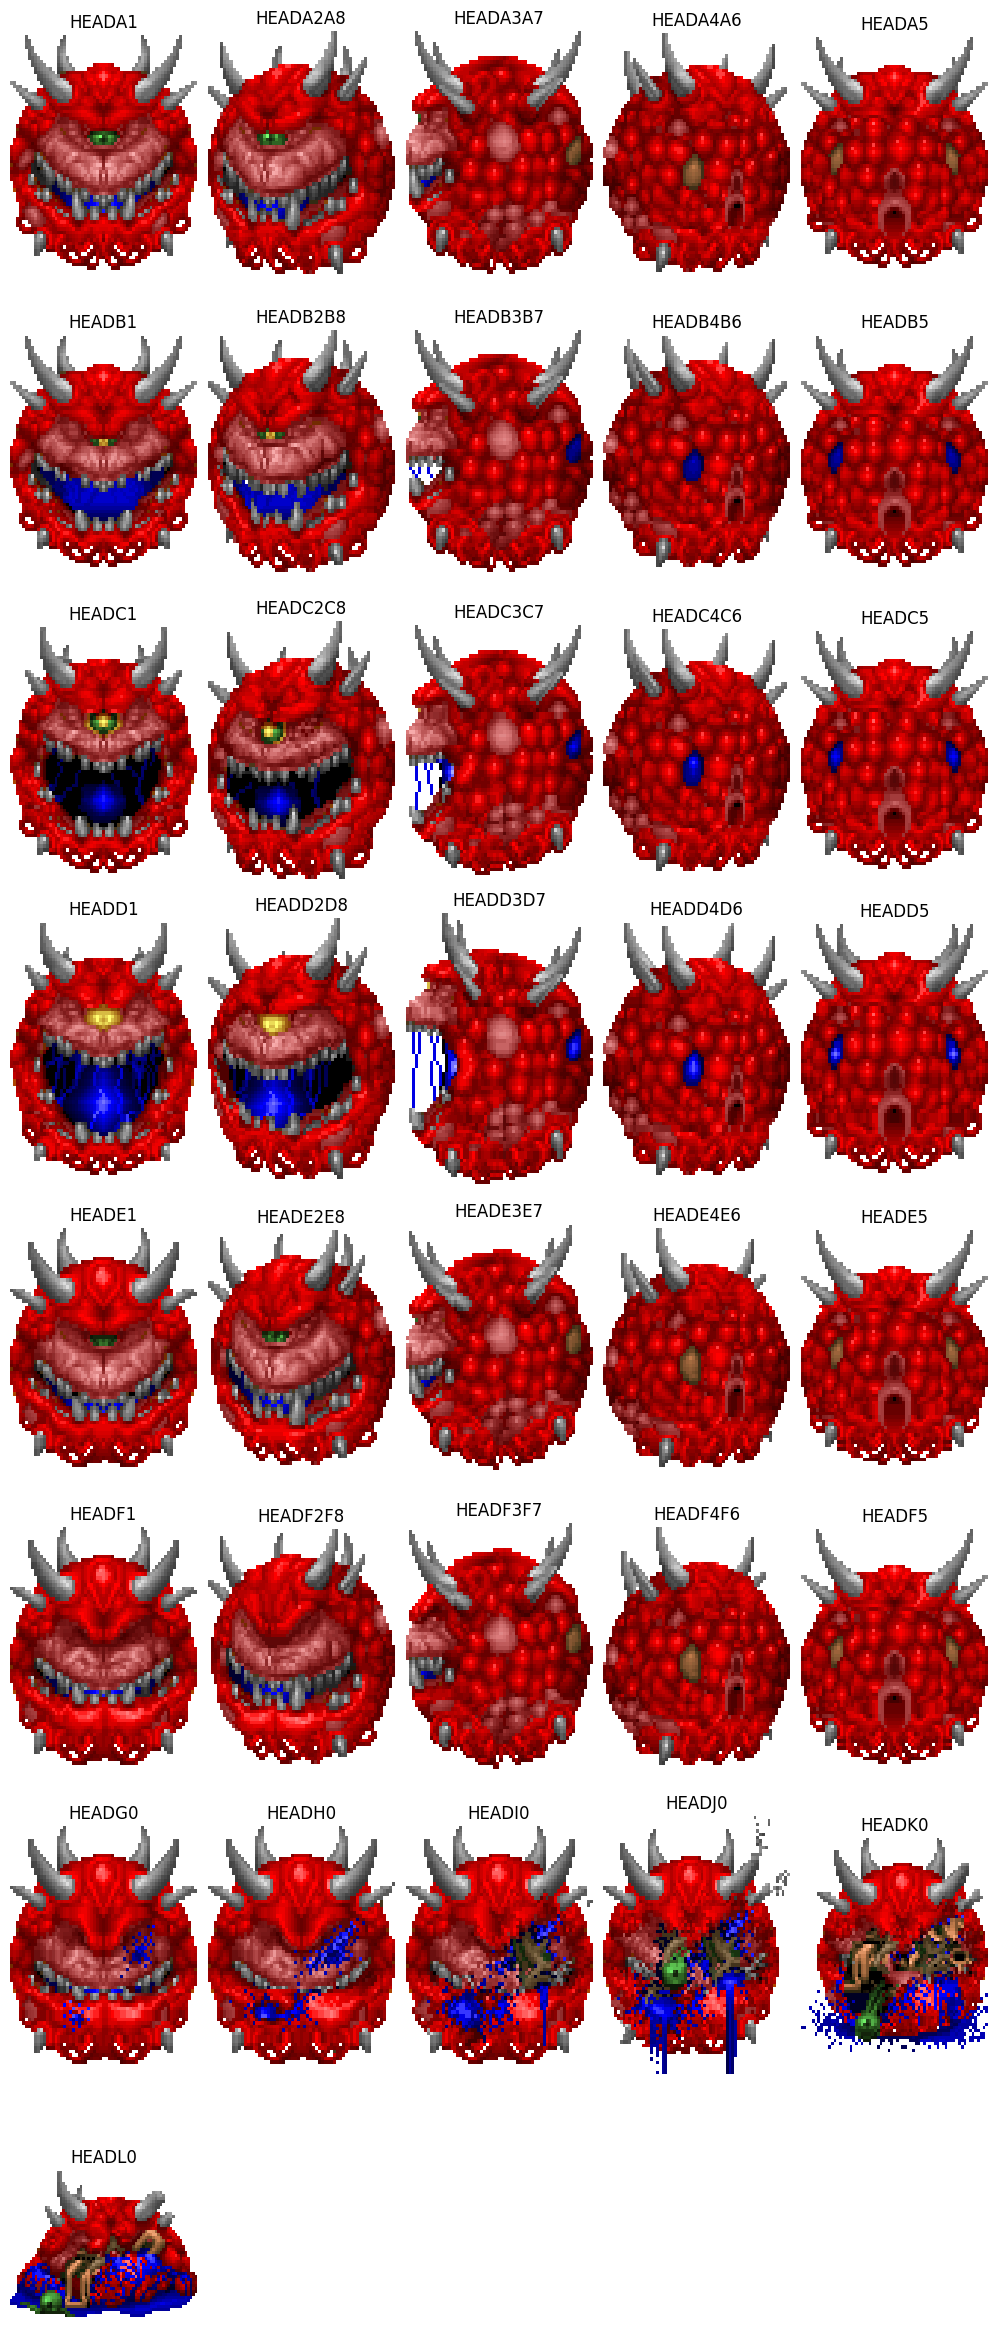

In [31]:
sprite_name = 'HEAD'

sprite_list = w.spritesheets[sprite_name]
ncols=5
nrows = int(np.ceil(len(sprite_list) / ncols))

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*nrows))
ax = ax.ravel()

for i, (name, offset, size) in enumerate(sprite_list):
    
    rgb_image = w.draw_patch(offset, size)
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest')
    ax[i].set_title(name)
    ax[i].axis('off')

[ax[i].set_visible(False) for i in range(len(sprite_list), len(ax))]
fig.tight_layout(pad=0.8)

In [32]:
w.lump_names

['PLAYPAL',
 'COLORMAP',
 'ENDOOM',
 'DEMO1',
 'DEMO2',
 'DEMO3',
 'DEMO4',
 'E1M1',
 'THINGS',
 'LINEDEFS',
 'SIDEDEFS',
 'VERTEXES',
 'SEGS',
 'SSECTORS',
 'NODES',
 'SECTORS',
 'REJECT',
 'BLOCKMAP',
 'E1M2',
 'THINGS',
 'LINEDEFS',
 'SIDEDEFS',
 'VERTEXES',
 'SEGS',
 'SSECTORS',
 'NODES',
 'SECTORS',
 'REJECT',
 'BLOCKMAP',
 'E1M3',
 'THINGS',
 'LINEDEFS',
 'SIDEDEFS',
 'VERTEXES',
 'SEGS',
 'SSECTORS',
 'NODES',
 'SECTORS',
 'REJECT',
 'BLOCKMAP',
 'E1M4',
 'THINGS',
 'LINEDEFS',
 'SIDEDEFS',
 'VERTEXES',
 'SEGS',
 'SSECTORS',
 'NODES',
 'SECTORS',
 'REJECT',
 'BLOCKMAP',
 'E1M5',
 'THINGS',
 'LINEDEFS',
 'SIDEDEFS',
 'VERTEXES',
 'SEGS',
 'SSECTORS',
 'NODES',
 'SECTORS',
 'REJECT',
 'BLOCKMAP',
 'E1M6',
 'THINGS',
 'LINEDEFS',
 'SIDEDEFS',
 'VERTEXES',
 'SEGS',
 'SSECTORS',
 'NODES',
 'SECTORS',
 'REJECT',
 'BLOCKMAP',
 'E1M7',
 'THINGS',
 'LINEDEFS',
 'SIDEDEFS',
 'VERTEXES',
 'SEGS',
 'SSECTORS',
 'NODES',
 'SECTORS',
 'REJECT',
 'BLOCKMAP',
 'E1M8',
 'THINGS',
 'LINEDEFS',
 '

In [29]:
music = 'D_E1M3'
idx = w.lump_names.index(music)
name, offset, size = w.lumps[idx]

w.wad.seek(offset)
lump = w.wad.read(size)

lump

b'MUS\x1a.K\x1e\x00\x02\x00\x00\x00\x07\x00\x00\x00&\x00\\\x00\x88\x00\x8c\x00\x8e\x00\x99\x00\x9f\x00@\x00&@\x03d@\x04@@\x01\x00\x10\xa7?A\x00\\A\x03dA\x04TO\x00\x00\x9f\xa4_\x11\x00\'\x10\'\x8f$\x12\x00\'\x90\'\x11\x00\'\x90\'\x12\x00\'\x90\'\x11\x00\'\x90\'\x12\x00\'\x10\'\x9f$\x11\x00\'\x10\'\x8f$\x12\x00\'\x10\'\x9f(\x11\x00\'\x10\'\x8f(\x12\x00\'\x90\'\x11\x00\'\x90\'\x12\x00\'\x90\'\x11\x00\'\x90\'\x12\x00\'\x90\'\x11\x00\'\x90\'\x12\x00\'\x10\'\x9f$\x11\x00\'\x10\'\x8f$\x12\x00\'\x90\'\x11\x00\'\x90\'\x12\x00\'\x90\'\x11\x00\'\x90\'\x12\x00\'\x10\'\x9f$\x11\x00\'\x10\'\x8f$\x12\x00\'\x10\'\x9f(\x11\x00\'\x10\'\x8f(\x12\x00\'\x90\'\x11\x00\'\x90\'\x12\x00\'\x90\'\x11\x00\'\x90\'\x12\x00\'\x90\'\x11\x00\'\x90\'\x12\x00\'\x10\'\x9f$\x11\x00\'\x10\'\x8f$\x12\x00\'\x90\'\x11\x00\'\x90\'\x12\x00\'\x90\'\x11\x00\'\x90\'\x12\x00\'\x10\'\x9f$\x11\x00\'\x10\'\x8f$\x12\x00\'\x10\'\x9f(\x11\x00\'\x10\'\x8f(\x12\x00\'\x90\'\x11\x00\'\x90\'\x12\x00\'\x90\'\x11\x00\'\x90\'\x12\x00\'\x90\'\x11

In [30]:
with open("input.mus", "wb") as f:
    f.write(lump)

In [31]:
with open('input.mus', 'rb') as musinput, open('output.mid', 'wb') as midioutput:
    mus2mid(musinput, midioutput)

2025-03-21 12:17:57.960 | INFO     | mus2mid3:mus2mid:125 - MUS file header: MusHeader(id=b'MUS\x1a', scorelength=19246, scorestart=30, primarychannels=2, secondarychannels=0, instrumentcount=7)


In [23]:
w.wad.seek(offset)
MUS_header, score_len, score_start, channels, sec_channels, instrCnt, dummy = struct.unpack("<4sHHHHHH", w.wad.read(16))
instrList = struct.unpack(f"<{instrCnt}h", w.wad.read(instrCnt * 2))
f"{score_len=}", score_start, channels, sec_channels, instrCnt, instrList

('score_len=17237',
 46,
 3,
 0,
 15,
 (29, 30, 34, 136, 138, 140, 141, 145, 146, 147, 149, 150, 151, 153, 157))